# Import Statements

In [1]:
import numpy as np
import pandas as pd
import math
import cmath
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import scipy
from scipy import signal

import watermark 

# GPU code

In [2]:
# This will throw an error if you don't have a GPU

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Adjustments

In [3]:
# Changes these variables to test different parameters for the NN

# Change the data being sent to the NN
numberofSamples = 1000 # changes number of time signal run the geo sim. How much data is being sent to NN
test_numberofSamples = numberofSamples # number of test signals to see results of the NN
N = 1024 # size of the sample taken from Luke's file

# Change parameters of the NN
ACTIVATION_FUNCTION = 'sigmoid' # activation function being used for the NN 

LEARNING_RATE = 0.00001 # learning rate for NN

EPOCHS = 1000 # number of epochs for the NN
BATCH_SIZE = 20 # batchsize for the NN

# Data Setup for Geo Sim

In [4]:
# File from Luke
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is
# samples = np.ones(N,)

test = np.array(samples)
print(test.shape)

(1000000,)


In [5]:
# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(3) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element

# Antenna Geometry
horz_elements = 2 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# creating blank arrays to store the values from the geometry simulator
elements = [[], []] # empty matrix to store each elements data
angleofArrival = [] # empty matrix to store DoA
print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 

[[], []]


In [6]:
# shrinking the size of the signal so it is easier to work with
# Will want to take random samples from this at some point
small_samples = np.zeros(N, complex) # blank array to store the data

# Create smaller signal to work with
for i in range(N):
    small_samples[i] = samples[i]

# checking the size of the sample
print(small_samples.shape)

(1024,)


# Geo Sim

In [7]:
# Generating the Data for the NN
for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(2)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(2) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(2) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    # converting the signal into the frequency domain
    fsmall_samples = np.fft.fft(small_samples)
    fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    # shifting the signal in the frequency domain
    shift0 = fsmall_samples*np.exp(-1j*2*np.pi*fs*totaltd[0])
    shift1 = fsmall_samples*np.exp(-1j*2*np.pi*fs*totaltd[1])
    
    shift0 = np.fft.ifftshift(shift0)
    shift1 = np.fft.ifftshift(shift1)
    
    # converting from frequency domain back to time domain
    shift0 = np.fft.ifft(shift0)
    shift1 = np.fft.ifft(shift1)
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift0) # storing the data for element 2 
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[0.00000000e+00 1.74092012e-11]
[4.88804493 4.89909245]


# Verifying Geo Sim Out

In [8]:
# checking the shape and values for element 1
# element1 = np.array(elements[0]) 
# print(element1.shape)

# checking the shape and values for elements
# testEle1 = np.array(elements)
# print(testEle1.shape)

# for i in element1[2]:
#     print(i)

In [9]:
# checking the shape and values for element 1
# element2 = np.array(elements[1])
# print(element2.shape)

# checking the shape and values for elements
# testEle2 = np.array(elements)
# print(testEle2.shape)

# for i in element2[2]:
#     print(i)

In [10]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

# for i in angleofArrival:
#     print(i)

(1000,)


# Cross Correlation

In [11]:
# Data setup for the correlation and averaging
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(1000, 1024)
(1024,)


In [12]:
# corr each time step then take the mean
corr = []  # creating a blank array to store the correlations in

corr = signal.correlate(element1, element2, mode='same', method='auto')

test = np.array(corr)
print(test.shape)

(1000, 1024)


# Cross Correlation Output

13.93184434750708


C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-13-7a5dfe857ad9>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


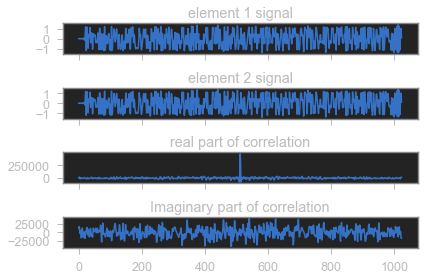

In [13]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 0
print(angleofArrival[sample])

# Element 1
ax_signal1.plot(element1[sample])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

-8.416369225200746


C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-14-2ced395ea2ad>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


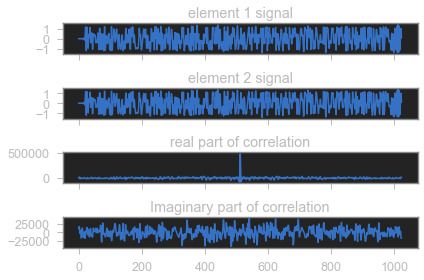

In [14]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 1
print(angleofArrival[sample])

# Element 1
ax_signal1.plot(element1[sample])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

# Complex to Polar

In [15]:
# Concatinating the real and imag parts of the correlation
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=-1)
print(complexCorr.shape)

(1000, 2048)


In [16]:
# Converting to polar from complex
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr, np.zeros((numberofSamples, N))), axis=-1)
print(polarCorr.shape)

for j in range(numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        polarCorr[j][i] = temp
        polarCorr[j][N+i] = temp2

print('--------------------')
print(polarCorr.shape)
print(polarCorr[0].shape)

polarCorr = np.real(polarCorr)

(1000, 1024)
(1000, 2048)
--------------------
(1000, 2048)
(2048,)


# Data for NN

In [17]:
# Setting the label and feature
angleofArrival = np.array(angleofArrival)

train_labels = angleofArrival
train_samples = polarCorr

In [18]:
print(train_samples.shape)

# for i in train_samples:
#     print(i)

(1000, 2048)


In [19]:
print(train_labels.shape)

# for i in train_labels:
#     print(i)

(1000,)


In [20]:
# scaling the NN between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1 was 0,1

scaled_train_samples = scaler.fit_transform(train_samples)
scaled_train_labels = scaler.fit_transform(train_labels.reshape(-1,1)) #  this is reshaping from (100,) to (100,1)

In [21]:
print(scaled_train_samples.shape)

# for i in scaled_train_samples:
#     print(i)

(1000, 2048)


In [22]:
print(scaled_train_labels.shape)

# for i in scaled_train_labels:
#     print(i)

(1000, 1)


# Build NN

In [23]:
# Testing the flatten layer to get output shape
# Create a `Sequential` model and add a Dense layer as the first layer.  
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(N*2))) 
model.add(tf.keras.layers.Dense(128, activation = ACTIVATION_FUNCTION))
model.add(tf.keras.layers.Dense(128, activation = ACTIVATION_FUNCTION))
model.add(tf.keras.layers.Dense(128, activation = ACTIVATION_FUNCTION))
# model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(64, activation = ACTIVATION_FUNCTION))
model.add(tf.keras.layers.Dense(64, activation = ACTIVATION_FUNCTION))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.output_shape

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6

In [24]:
model.compile(
    optimizer=Adam(learning_rate = LEARNING_RATE),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
history = model.fit(
    x = scaled_train_samples, # checking what happens without scaling, must have scaling
    y = scaled_train_labels,  # checking what happens without scaling, training was progressing
    validation_split = 0.1,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS, 
    verbose = 2)

Epoch 1/1000
45/45 - 0s - loss: 1.5577 - root_mean_squared_error: 1.2481 - val_loss: 1.4405 - val_root_mean_squared_error: 1.2002
Epoch 2/1000
45/45 - 0s - loss: 1.3905 - root_mean_squared_error: 1.1792 - val_loss: 1.2878 - val_root_mean_squared_error: 1.1348
Epoch 3/1000
45/45 - 0s - loss: 1.2375 - root_mean_squared_error: 1.1124 - val_loss: 1.1493 - val_root_mean_squared_error: 1.0720
Epoch 4/1000
45/45 - 0s - loss: 1.0991 - root_mean_squared_error: 1.0484 - val_loss: 1.0220 - val_root_mean_squared_error: 1.0110
Epoch 5/1000
45/45 - 0s - loss: 0.9736 - root_mean_squared_error: 0.9867 - val_loss: 0.9068 - val_root_mean_squared_error: 0.9523
Epoch 6/1000
45/45 - 0s - loss: 0.8611 - root_mean_squared_error: 0.9279 - val_loss: 0.8025 - val_root_mean_squared_error: 0.8958
Epoch 7/1000
45/45 - 0s - loss: 0.7595 - root_mean_squared_error: 0.8715 - val_loss: 0.7098 - val_root_mean_squared_error: 0.8425
Epoch 8/1000
45/45 - 0s - loss: 0.6691 - root_mean_squared_error: 0.8180 - val_loss: 0.626

Epoch 64/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 65/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 66/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 67/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 68/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 69/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 70/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 71/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_los

Epoch 127/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3483
Epoch 128/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3482
Epoch 129/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3483
Epoch 130/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3483
Epoch 131/1000
45/45 - 0s - loss: 0.1125 - root_mean_squared_error: 0.3354 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3482
Epoch 132/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3483
Epoch 133/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1213 - val_root_mean_squared_error: 0.3483
Epoch 134/1000
45/45 - 0s - loss: 0.1125 - root_mean_squared_error: 0.3354 -

45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 190/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 191/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 192/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 193/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 194/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 195/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 196/1000
45/45 - 0s - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.12

Epoch 252/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 253/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 254/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 255/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 256/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 257/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 258/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 259/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 -

45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 315/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 316/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 317/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 318/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 319/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1217 - val_root_mean_squared_error: 0.3488
Epoch 320/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 321/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3350 - val_loss: 0.12

Epoch 377/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 378/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3349 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 379/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 380/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3349 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 381/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 382/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 383/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3349 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 384/1000
45/45 - 0s - loss: 0.1123 - root_mean_squared_error: 0.3351 -

45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 440/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 441/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3349 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 442/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 443/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 444/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 445/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 446/1000
45/45 - 0s - loss: 0.1122 - root_mean_squared_error: 0.3349 - val_loss: 0.12

Epoch 502/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3495
Epoch 503/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3495
Epoch 504/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3495
Epoch 505/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3346 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3495
Epoch 506/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 507/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 508/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 509/1000
45/45 - 0s - loss: 0.1121 - root_mean_squared_error: 0.3348 -

45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3346 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3498
Epoch 565/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3346 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3498
Epoch 566/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3346 - val_loss: 0.1223 - val_root_mean_squared_error: 0.3498
Epoch 567/1000
45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3498
Epoch 568/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3498
Epoch 569/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3498
Epoch 570/1000
45/45 - 0s - loss: 0.1120 - root_mean_squared_error: 0.3346 - val_loss: 0.1225 - val_root_mean_squared_error: 0.3499
Epoch 571/1000
45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3346 - val_loss: 0.12

Epoch 627/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1225 - val_root_mean_squared_error: 0.3501
Epoch 628/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 629/1000
45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 630/1000
45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 631/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 632/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 633/1000
45/45 - 0s - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3501
Epoch 634/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 -

45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3343 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504
Epoch 690/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504
Epoch 691/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3343 - val_loss: 0.1229 - val_root_mean_squared_error: 0.3505
Epoch 692/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3505
Epoch 693/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3505
Epoch 694/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3344 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3505
Epoch 695/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3343 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504
Epoch 696/1000
45/45 - 0s - loss: 0.1118 - root_mean_squared_error: 0.3343 - val_loss: 0.12

Epoch 752/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3341 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 753/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 754/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3508
Epoch 755/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3343 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 756/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 757/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 758/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3508
Epoch 759/1000
45/45 - 0s - loss: 0.1117 - root_mean_squared_error: 0.3342 -

45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1233 - val_root_mean_squared_error: 0.3511
Epoch 815/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510
Epoch 816/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3511
Epoch 817/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510
Epoch 818/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1234 - val_root_mean_squared_error: 0.3512
Epoch 819/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510
Epoch 820/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510
Epoch 821/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.12

Epoch 877/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1235 - val_root_mean_squared_error: 0.3514
Epoch 878/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3516
Epoch 879/1000
45/45 - 0s - loss: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.1235 - val_root_mean_squared_error: 0.3514
Epoch 880/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.1235 - val_root_mean_squared_error: 0.3514
Epoch 881/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3515
Epoch 882/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.1234 - val_root_mean_squared_error: 0.3513
Epoch 883/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3339 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3516
Epoch 884/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3339 -

45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 940/1000
45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3337 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 941/1000
45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3337 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3518
Epoch 942/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3339 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3516
Epoch 943/1000
45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 944/1000
45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 945/1000
45/45 - 0s - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3518
Epoch 946/1000
45/45 - 0s - loss: 0.1115 - root_mean_squared_error: 0.3338 - val_loss: 0.12

In [26]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# Gather the history (a snapshot) of each epoch.
hist = pd.DataFrame(history.history)

# Specifically gather the model's root mean squared error at each epoch.
rmse = hist["root_mean_squared_error"]

# Test Data (Same as cells 2-7 but merged)

In [27]:
# array of all the elements, works for 3 elements
test_elements = [[], []]
test_AngleofArrival = []

In [28]:
# Generating the Data for the NN
for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(3)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(3) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(3) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    # converting the signal into the frequency domain
    fsmall_samples = np.fft.fft(small_samples)
    fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    # shifting the signal in the frequency domain
    shift0 = fsmall_samples*np.exp(-1j*2*np.pi*fs*totaltd[0])
    shift1 = fsmall_samples*np.exp(-1j*2*np.pi*fs*totaltd[1])
    
    shift0 = np.fft.ifftshift(shift0)
    shift1 = np.fft.ifftshift(shift1)
    
    # converting from frequency domain back to time domain
    shift0 = np.fft.ifft(shift0)
    shift1 = np.fft.ifft(shift1)
    
    # storing the data
    test_elements[0].append(shift0) # storing the data for element 1
    test_elements[1].append(shift0) # storing the data for element 2 
    test_AngleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[1.36164572e-06 1.36168120e-06 0.00000000e+00]
[10.00765379 10.01611032  0.        ]


In [29]:
# Data setup for the correlation and averaging
test_element1 = np.array(test_elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
test_element2 = np.array(test_elements[1])

test = np.array(test_element1[0])
print(test_element1.shape)
print(test.shape)

(1000, 1024)
(1024,)


In [30]:
test_corr = []

test_corr = signal.correlate(test_element1, test_element2, mode='same', method='auto')

test = np.array(test_corr)
print(test.shape)

(1000, 1024)


In [31]:
# Converting to polar from complex
tempCorr = np.array(test_corr)
print(tempCorr.shape)

test_polarCorr = np.concatenate((tempCorr, np.zeros((test_numberofSamples, N))), axis=-1)
print(test_polarCorr.shape)

for j in range(test_numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        test_polarCorr[j][i] = temp
        test_polarCorr[j][N+i] = temp2

print('--------------------')
print(test_polarCorr.shape)
print(test_polarCorr[0].shape)

test_polarCorr = np.real(test_polarCorr)

(1000, 1024)
(1000, 2048)
--------------------
(1000, 2048)
(2048,)


In [32]:
# Setting the label and feature
test_angleofArrival = np.array(test_AngleofArrival)

test_labels = test_angleofArrival
test_samples = test_polarCorr

In [33]:
# scaling the NN between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1 was 0,1

scaled_test_samples = scaler.fit_transform(test_samples)
scaled_test_labels = scaler.fit_transform(test_labels.reshape(-1,1)) #  this is reshaping from (100,) to (100,1)

# Predict

In [34]:
predictions = model.predict(x=scaled_test_samples, batch_size=1, verbose=0)
testMaxAngle = max(test_AngleofArrival)
testMinAngle = min(test_AngleofArrival)

scaler = MinMaxScaler(feature_range=(testMinAngle,testMaxAngle))

In [35]:
for i in predictions:
    print(i)

[-0.03356451]
[-0.04060409]
[-0.04027273]
[-0.02660203]
[-0.03167685]
[-0.03429376]
[-0.03263513]
[-0.0386619]
[-0.02925275]
[-0.0340631]
[-0.02770509]
[-0.02869573]
[-0.02832233]
[-0.03631618]
[-0.03562267]
[-0.0343456]
[-0.03805157]
[-0.03551799]
[-0.03196472]
[-0.03112496]
[-0.03040466]
[-0.03630629]
[-0.03857705]
[-0.02797908]
[-0.03917413]
[-0.03423993]
[-0.02873481]
[-0.03977256]
[-0.02670282]
[-0.03145834]
[-0.03326381]
[-0.04370749]
[-0.03965792]
[-0.02874868]
[-0.03147062]
[-0.03256597]
[-0.04283525]
[-0.03177479]
[-0.03175094]
[-0.03121777]
[-0.03114699]
[-0.03669037]
[-0.03614522]
[-0.0320024]
[-0.03981667]
[-0.03459486]
[-0.04325693]
[-0.03691496]
[-0.03130216]
[-0.03330182]
[-0.0311476]
[-0.03609227]
[-0.02929303]
[-0.03978592]
[-0.03678958]
[-0.03339684]
[-0.03051314]
[-0.03491954]
[-0.034988]
[-0.03128014]
[-0.03352414]
[-0.03032241]
[-0.03630689]
[-0.03764999]
[-0.03082504]
[-0.03487005]
[-0.03059372]
[-0.03725548]
[-0.03800321]
[-0.03092735]
[-0.03137884]
[-0.03477488]

[-0.03595201]
[-0.03109311]
[-0.04015693]
[-0.03123761]
[-0.03407222]
[-0.03025076]
[-0.03421029]
[-0.03582247]
[-0.03369281]
[-0.03262462]
[-0.02789856]
[-0.0306938]
[-0.03676705]
[-0.0369752]
[-0.03434866]
[-0.03703244]
[-0.0277337]
[-0.02810215]
[-0.04252185]
[-0.03880661]
[-0.03392402]
[-0.04075662]
[-0.03739056]
[-0.03733743]
[-0.02911567]
[-0.02678787]
[-0.02912842]
[-0.03659847]
[-0.04284275]
[-0.0306938]
[-0.03202114]
[-0.02710306]
[-0.03502885]
[-0.0268097]
[-0.0369304]
[-0.02971155]
[-0.04122689]
[-0.03095642]
[-0.0305708]
[-0.02771904]
[-0.03388583]
[-0.03007661]
[-0.03693412]
[-0.03344009]
[-0.03028777]
[-0.0379095]
[-0.02824807]
[-0.0301392]
[-0.0363392]
[-0.03648524]
[-0.03389357]
[-0.03863228]
[-0.03135078]
[-0.02954885]
[-0.03194778]
[-0.03519397]
[-0.0421274]
[-0.03599313]
[-0.03503992]
[-0.02820162]
[-0.03663031]
[-0.03053623]
[-0.03817646]
[-0.02806238]
[-0.03930649]
[-0.04063741]
[-0.02771221]
[-0.03535476]
[-0.0396888]
[-0.03197253]
[-0.03896564]
[-0.03917182]
[-0.

In [36]:
for i in scaled_test_labels:
    print(i)

[0.19524689]
[0.21475553]
[-0.60063274]
[-0.12608167]
[0.69250489]
[0.02228066]
[-0.07581161]
[0.26080737]
[-0.36690956]
[0.34491717]
[0.40784883]
[-0.01835311]
[-0.57322964]
[0.75568904]
[0.38927774]
[0.65363798]
[-0.39955521]
[0.49136812]
[-0.09843244]
[0.22601848]
[0.23558099]
[0.28733044]
[-0.4172386]
[0.0446277]
[0.25588359]
[0.25456491]
[0.24464825]
[0.22010325]
[-0.17987038]
[-0.16661494]
[-0.00447305]
[0.08059578]
[0.05694218]
[0.18579051]
[0.14995512]
[-0.37792611]
[-0.78283745]
[-0.38866978]
[0.02779839]
[0.23789798]
[0.31530837]
[-0.09203346]
[-0.28523233]
[-0.08270549]
[0.13697882]
[0.42771218]
[0.22665365]
[0.29126943]
[-0.09695469]
[-0.2684107]
[-0.00282743]
[0.39444924]
[0.26163274]
[-0.61991783]
[0.13328065]
[-0.56661762]
[0.40176816]
[0.10260335]
[-0.81487599]
[-0.1559606]
[0.15207102]
[-0.37594028]
[-0.26520231]
[-0.13456406]
[-0.33410768]
[-0.43959078]
[0.24160711]
[-0.16978904]
[0.42231865]
[-0.23909172]
[-0.19632763]
[-0.16970715]
[0.27938797]
[0.19192884]
[0.00171

[-0.21308503]
[0.23804333]
[0.10549866]
[-0.21380551]
[0.34378606]
[-0.38477993]
[-0.43150578]
[-0.57393165]
[-0.28179675]
[-0.10341226]
[-0.61609006]
[-0.77568968]
[-0.29898086]
[-0.34082215]
[-0.25839602]
[0.09630483]
[0.10449044]
[-0.27908208]
[0.02131303]
[0.85671404]
[0.3421571]
[0.2961533]
[0.05030276]
[-0.04950541]
[0.11242646]
[-0.32429974]
[0.39932409]
[0.02506818]
[-0.00881474]
[0.1225939]
[0.59790066]
[-0.20254399]
[0.3032557]
[0.04592946]
[0.06338036]
[-0.02297082]
[-0.07729097]
[-0.51392539]
[-0.09317309]
[0.16553283]
[0.09456117]
[0.96077552]
[0.02551108]
[-0.25019708]
[0.07779865]
[-0.18787628]
[-0.29850059]
[0.15600663]
[0.28264327]
[0.00877109]
[0.13126239]
[0.13261438]
[0.29785848]
[-0.01053234]
[-0.08141243]
[0.93782313]
[-0.12143295]
[0.1282765]
[0.02186698]
[0.03196709]
[-0.65457732]
[-0.30573212]
[-0.45791322]
[-1.]
[0.02766148]
[-0.04209998]
[0.04369197]
[-0.15152332]
[-0.46754194]
[-0.36908153]
[0.41080039]
[-0.59413806]
[-0.04308396]
[-0.36791655]
[0.071488]
[0

In [37]:
print(np.argmax(predictions))
print('--------------------')
print(predictions.shape)

500
--------------------
(1000, 1)


In [38]:
print(np.argmin(predictions))
print('--------------------')
print(predictions.shape)

31
--------------------
(1000, 1)


In [39]:
print(np.argmax(scaled_test_labels))
print('--------------------')
print(scaled_test_labels.shape)

652
--------------------
(1000, 1)


In [40]:
print(np.argmin(scaled_test_labels))
print('--------------------')
print(scaled_test_labels.shape)

827
--------------------
(1000, 1)


In [41]:
# Testing some stuff
# scaling the test data 
scaler = MinMaxScaler(feature_range=(np.min(test_labels),np.max(test_labels))) 
scaled_predictions = scaler.fit_transform(predictions)

for i in scaled_predictions:
    print(i)

[-10.662262]
[-31.42411]
[-30.446838]
[9.872223]
[-5.094963]
[-12.813034]
[-7.9212418]
[-25.696007]
[2.0544357]
[-12.132736]
[6.618973]
[3.697258]
[4.7985306]
[-18.777771]
[-16.732384]
[-12.965927]
[-23.895966]
[-16.423676]
[-5.9439697]
[-3.4672623]
[-1.3428802]
[-18.748589]
[-25.44577]
[5.810875]
[-27.206726]
[-12.654274]
[3.5820007]
[-28.97168]
[9.574959]
[-4.450508]
[-9.775406]
[-40.57698]
[-28.633583]
[3.541092]
[-4.48674]
[-7.7172546]
[-38.00448]
[-5.383835]
[-5.313469]
[-3.7410202]
[-3.5322418]
[-19.881355]
[-18.27356]
[-6.0551147]
[-29.101784]
[-13.701073]
[-39.24816]
[-20.54374]
[-3.989891]
[-9.887497]
[-3.5340424]
[-18.117386]
[1.935646]
[-29.011078]
[-20.173958]
[-10.167732]
[-1.6628189]
[-14.658653]
[-14.86055]
[-3.9249573]
[-10.543182]
[-1.1003113]
[-18.750374]
[-22.711563]
[-2.582718]
[-14.512703]
[-1.9004974]
[-21.548058]
[-23.753326]
[-2.884468]
[-4.216049]
[-14.232002]
[-36.09781]
[-2.190796]
[-15.8728485]
[-7.8930893]
[-9.93782]
[-11.329987]
[-28.014053]
[-17.605698]
[

[-7.7317123]
[-0.3815155]
[-7.2159195]
[-20.41996]
[-8.436264]
[-17.920609]
[-16.483925]
[-22.452553]
[-23.47496]
[-8.547279]
[-18.712006]
[-29.907707]
[-22.121536]
[-6.839348]
[-9.659935]
[6.9936295]
[-14.493782]
[9.160202]
[-27.35138]
[-7.8487015]
[0.37043762]
[-29.746284]
[5.7034454]
[-15.306183]
[-5.038292]
[-20.035393]
[-11.360329]
[-18.62532]
[-8.030624]
[-10.383629]
[4.3506546]
[-21.903908]
[3.5466232]
[-11.706551]
[-8.374123]
[-1.4220123]
[-5.794922]
[3.9175262]
[5.234543]
[-2.0950317]
[-20.387085]
[-19.083496]
[-23.700172]
[0.8572922]
[-4.3223343]
[6.669029]
[-14.734024]
[-1.6396637]
[2.1648102]
[-33.568314]
[-15.208359]
[-20.344276]
[-36.09008]
[-5.7670364]
[-18.807396]
[-13.968842]
[-32.55149]
[-3.5210342]
[-34.17906]
[-30.283592]
[-11.799675]
[-32.208473]
[-4.349098]
[-16.467842]
[-13.723129]
[-17.945862]
[-1.8001633]
[-1.1097107]
[-15.78199]
[-1.7997665]
[-37.24015]
[1.5014191]
[-5.811775]
[-18.841324]
[-3.684433]
[9.163696]
[-2.6249313]
[-34.507637]
[-9.227356]
[-4.836853

In [42]:





for i in test_labels:
    print(i)

7.821102053753105
8.611048294143258
-24.405753974945778
-5.190173795242752
27.956134352062413
0.8173322268547877
-3.154632292889182
10.475785250731644
-14.941806355778322
13.881569372652653
16.429806181535895
-0.8280156476787329
-23.296144416486683
30.514594785645308
15.677823252889636
26.382330447233684
-16.263697834876165
19.811679490087606
-4.070597535236696
9.067109019069097
9.45431560041914
11.549760554361848
-16.979736034852493
1.7222112167354975
10.276410656508622
10.223014803695248
9.821468096542803
8.827588961131326
-7.36819276872245
-6.831451697206009
-0.2659824070831296
3.178635370233443
2.2208505984782794
7.438193190612215
5.9871420908446495
-15.387889937980749
-31.78360986946776
-15.822923929687782
1.0407568174700548
9.548135409116995
12.682646404397119
-3.811489288390072
-11.63452196091873
-3.433780003995722
5.461704165872599
17.234115063807476
9.092828533048111
11.709258687294156
-4.010760293981759
-10.953378157513368
-0.19934758114555587
15.88722826906617
10.50920592017

2.0466454704937047
-2.2081295087090766
17.323069130048108
-18.954376426274788
-1.9230580452395651
9.924489420855814
-21.57873481283045
-1.797525295733578
16.564423236153285
9.45139001620786
0.983974982136082
19.097024320721605
12.239986383388189
24.064849749153904
-10.11756292252206
-1.5122002159212409
21.457280771211614
-18.448093360213946
-0.010190343137600711
4.543574121038611
6.997770198746923
17.833413158230098
-1.5728396286459865
-5.8526328793382625
-12.001543227624156
-33.47509163538706
11.383755706637016
-7.697917223141851
-14.730366071427644
10.33997064182765
-2.312568155363522
11.430062490969382
-27.89795201903097
0.692978832877447
0.5756888914559298
-11.406506242807605
-30.70790233761765
-8.335385095826824
-20.983289152652183
-3.9273929147275335
19.937280884828287
3.2552223257107493
9.453837582204095
11.04236013758971
18.54291729527589
-12.851490879123158
-2.3114636387108036
40.08291140954768
-31.779589112820272
3.2320918140430814
-4.584593038373991
-28.776206901509372
-10.1

# Plotting Setup

In [43]:
def plot_the_loss_curve(epochs, rmse):
    """Plot the loss curve, which shows loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.title('Loss Curve')
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.xscale("log")
#     plt.yscale("log")
    plt.show()

# Plotting RMSE and Predictions

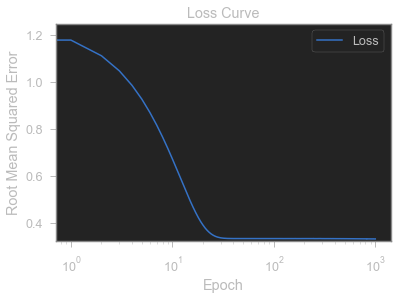

In [44]:
# plotting the RMSE vs epochs
plot_the_loss_curve(epochs, rmse)

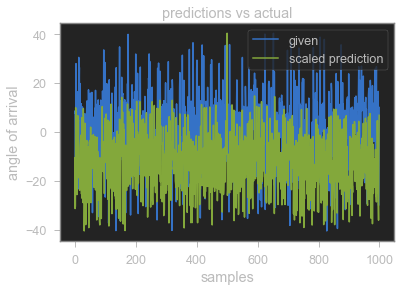

In [45]:
# scaling my output, I think I am doing this wrong, i should use getWeights or something
scaled_predictions = scaler.fit_transform(predictions)

plt.plot(test_labels)
plt.plot(scaled_predictions)
plt.xlabel("samples")
plt.ylabel("angle of arrival")
plt.title('predictions vs actual')
plt.legend(('given', 'scaled prediction'))

In [46]:
# changing predictions to (100,) from (100,1) so it can sorted
new_predictions = predictions.reshape((numberofSamples,))
scaled_new_predictions = scaled_predictions.reshape((numberofSamples,))

# sorting the predictions
new_predictions.sort()
scaled_new_predictions.sort()

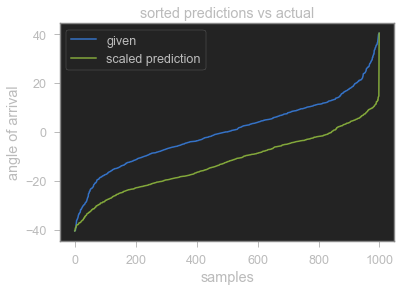

In [47]:
# plot_the_model
# plt.plot(new_predictions)
plt.plot(np.sort(test_labels))
plt.plot(scaled_new_predictions)
# plt.plot(predictions)
plt.xlabel("samples")
plt.ylabel("angle of arrival")
plt.title('sorted predictions vs actual')
plt.legend(('given', 'scaled prediction'))

# Water Mark

In [48]:
%load_ext watermark

%watermark -v -m -p math

CPython 3.8.3
IPython 7.18.1

math unknown

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores  : 8
interpreter: 64bit
